In [205]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import dirichlet

In [206]:
# load state data
state_df = pd.read_csv('../data/states.csv')

# drop all entries of Year_Semester including the word "Summer"
state_df = state_df[~state_df['Year_Semester'].str.contains('Summer')]

# drop all entries in Year_Semester prior to Fall 2021
cutoff = state_df[state_df['Year_Semester'] == 'Spring 2020']['Semester_Num'].values[0]
state_df = state_df[state_df['Semester_Num'] >= cutoff]

state_df

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester
4,3,10100,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Spring 2020
6,3,10104,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Fall 2020
7,3,10105,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Spring 2021
9,3,10109,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Fall 2021
10,3,10110,-1,0,0,0,-1,0,0,-1,-1,0,-1,0,1,1,0,Spring 2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84834,2186,10120,0,0,1,1,1,1,1,1,1,3,3,0,1,1,1,Spring 2024
84836,6481,10114,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Fall 2022
84837,6481,10115,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Spring 2023
84839,6481,10119,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Fall 2023


In [207]:
display(state_df[state_df['CSCI200'] == 2])
display(state_df[state_df['id'] == 3506])

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester


,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester
77705,3506,10104,0,0,1,1,1,1,1,1,1,3,3,-1,0,1,1,Fall 2020
77706,3506,10105,0,-2,-1,-1,1,-1,1,1,1,3,3,-1,-1,0,1,Spring 2021
77708,3506,10109,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Fall 2021
77709,3506,10110,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Spring 2022
77711,3506,10114,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Fall 2022
77712,3506,10115,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Spring 2023
77714,3506,10119,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Fall 2023
77715,3506,10120,0,-2,-2,-1,0,-1,1,1,1,2,2,-1,-1,0,1,Spring 2024


In [208]:
classes = ['CSCI128', 'CSCI200', 'CSCI220', 'CSCI274',
       'CSCI306', 'CSCI341', 'CSCI358', 'CSCI370', 'CSCI400', 'CSCI406',
       'CSCI442', 'MATH111', 'MATH112', 'MATH213', 'MATH332']

In [209]:
min_values = [state_df[c].min() for c in classes]
max_values = [state_df[c].max() for c in classes]
global_min = min(min_values)
global_max = max(max_values)

# normalize the data
if (global_max - global_min) < 10: 
    for c in classes:
        state_df[c] = state_df[c] - global_min
else: 
    print("ERROR: signature range is too large")

# set variables to count 
eligible = -1 * global_min

In [210]:
# create column concatenating all columns in classes
state_df['signature'] = state_df[classes].apply(lambda x: ''.join(x.astype(str)), axis=1)

# get list of all signatures
signatures = state_df['signature'].unique()


In [211]:
# create two networks: one showing Fall to Spring transitions, another showing Spring to Fall transitions
G_all = nx.DiGraph()

# add nodes to graph
G_all.add_nodes_from(signatures)

# add 0 weight edges between nodes
for s1 in signatures:
    for s2 in signatures:
        G_all.add_edge(s1, s2, weight=0)
        G_all.add_edge(s2, s1, weight=0)

In [212]:
for id in state_df['id'].unique(): 
    id_df = state_df[state_df['id'] == id]

    # get list in order of signatures
    sigs = id_df['signature'].tolist()

    # add 1 to weight of edge between each pair of signatures
    for i in range(len(sigs) - 1): 
        G_all[sigs[i]][sigs[i+1]]['weight'] += 1
    

# Dirichlet Sampling

In [213]:
# create alpha paramteters for each pair of signatures
num_signatures = len(signatures)
alpha_params = np.ones((num_signatures, num_signatures))

for i in range(len(signatures)):
    for j in range(len(signatures)):
        alpha_params[i][j] = G_all[signatures[i]][signatures[j]]['weight'] + 0.00001

In [214]:
# Assuming alpha_params is your NxN matrix where N is the number of states
N = len(alpha_params)
sampled_transition_matrices = np.zeros((N, N))

# Sample a transition matrix
for i in range(N):
    sampled_transition_matrices[i, :] = dirichlet.rvs(alpha_params[i], size=1)

# Calculating State Changes

In [215]:
def get_state_vector(year_semester):
    spring23_df = state_df[state_df['Year_Semester'] == year_semester]

    # reduce spring23_df to include counts of signatures
    spring23_df = spring23_df.groupby('signature').size().reset_index(name='count')

    # Ensure the DataFrame is ordered to match the Markov matrix
    df_ordered = spring23_df.set_index('signature').reindex(signatures).reset_index()

    # Now, df_ordered['count'] can be directly used as the state vector
    state_vector = df_ordered['count'].fillna(0).to_numpy()

    return state_vector

In [216]:
def count_taken(vector): 
    # create count dictionary
    count_dict = {cl:0 for cl in classes}

    for i in range(len(vector)):
        sig = signatures[i]
        for index,digit in enumerate(str(sig)): 
            if int(digit) < eligible: 
                count_dict[classes[index]] += vector[i]

    return count_dict

In [217]:
def get_enrollment(year_semester): 
    NUM_LIST = ['Cap', 'Act', 'Rem', 'WL Cap','WL Act','WL Rem','XL Cap','XL Act','XL Rem']
    CORE_LIST = ['128', '200', '220', '274', '306', '341', '358', '370', '400', '406', '442']

    # load schedule data
    name = year_semester.split(" ")[0] + year_semester.split(" ")[1][2:]
    schedule_df = pd.read_csv(f'../schedules/{name}.csv')

    # remove 102 entries
    df = schedule_df[schedule_df['Title'] != 'INTRODUCTION TO COMPUTER SCIENCE - LAB']

    # change CrseNum to string
    df['CrseNum'] = df['CrseNum'].astype(str)

    # replace equivalent classes
    df['CrseNum'] = df['CrseNum'].replace('101', '128')
    df['CrseNum'] = df['CrseNum'].replace('261', '200')
    df['CrseNum'] = df['CrseNum'].replace('262', '220')

    # replace equivalent course names
    df['Title'] = df['Title'].replace('INTRODUCTION TO COMPUTER SCIENCE', 'COMPUTER SCIENCE FOR STEM')
    df['Title'] = df['Title'].replace('PROGRAMMING CONCEPTS', 'FOUNDATIONAL PROGRAMMING CONCEPTS & DESIGN')
    df['Title'] = df['Title'].replace('DATA STRUCTURES', 'DATA STRUCTURES AND ALGORITHMS')

    # filter to only CrseNum in CORE_LIST
    df = df[df['CrseNum'].isin(CORE_LIST)]

    # set all columns in NUM_LIST to int
    for col in NUM_LIST:
        df.loc[:,col] = df[col].astype(int)

    # group by class and year
    core_df = df.groupby(['CrseNum','Title']).sum().reset_index()

    return core_df

In [218]:
def find_actual_pass(year_semester): 
    actual_df = pd.read_csv(f'../data/combined.csv')
    actual_df = actual_df[actual_df['Year_Semester'] == year_semester][['Class','Taken']]

    # convert actual_df into dictionary
    actual_dict = actual_df.set_index('Class').to_dict()['Taken']

    if 'CSCI370' not in actual_dict: 
        actual_dict['CSCI370'] = 0

    return actual_dict

In [219]:
semesters_list = ['Spring 2020', 'Fall 2021', 'Spring 2022', 'Fall 2022', 'Spring 2023', 'Fall 2023']

In [220]:
# create storage df
results_df = pd.DataFrame(columns=[
    'year_semester', 
    'class', 
    'true', 
    'mean difference', 
    'lower difference', 
    'upper difference',  
    'mean predicted pass', 
    'lower predicted pass', 
    'upper predicted pass',  
    'actual enrollment', 
    'capacity'
])

# just cs classes
cs_classes = [cl for cl in classes if cl[:4] == 'CSCI']

# get predictions
for index in range(1, len(semesters_list)):

    print(f"PREDICTING: {semesters_list[index].upper()}")

    # get input state vector
    state_vector = get_state_vector(semesters_list[index-1])

    # sample Dirichlet distributions
    samples = 1000
    predicted_state_vectors = np.zeros((samples, len(state_vector)))

    # Sample transition matrices
    for n in range(samples): 
        if n % 100 == 0:
            print(f"\tSample {n}")
        sampled_transition_matrix = np.vstack([dirichlet.rvs(alpha_params[i], size=1) for i in range(N)])
        predicted_state_vectors[n] = np.dot(state_vector, sampled_transition_matrix.T)

    mean_predicted_state = np.mean(predicted_state_vectors, axis=0)
    lower_bound = np.percentile(predicted_state_vectors, 5, axis=0)
    upper_bound = np.percentile(predicted_state_vectors, 95, axis=0)

    # get prediction counts
    mean_predicted_count_dict = count_taken(mean_predicted_state)
    lower_predicted_count_dict = count_taken(lower_bound)
    upper_predicted_count_dict = count_taken(upper_bound)

    # get actual passes
    actual_count_dict = find_actual_pass(semesters_list[index])

    # get previous semester
    prev_count_dict = count_taken(state_vector)

    # get enrollment
    enrollment = get_enrollment(semesters_list[index])

    # find difference prev and true
    true_comparison_dict = {cl: actual_count_dict[cl] for cl in cs_classes}

    # find difference prev and predicted
    mean_predicted_comparison_dict = {cl: mean_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}
    lower_predicted_comparison_dict = {cl: lower_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}
    upper_predicted_comparison_dict = {cl: upper_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

    # find error between true and predicted
    mean_difference_dict = {cl: actual_count_dict[cl] - mean_predicted_comparison_dict[cl] for cl in cs_classes}
    lower_difference_dict = {cl: actual_count_dict[cl] - lower_predicted_comparison_dict[cl] for cl in cs_classes}
    upper_difference_dict = {cl: actual_count_dict[cl] - upper_predicted_comparison_dict[cl] for cl in cs_classes}

    # find difference true and predicted
    for cl in cs_classes: 
        enroll_value = enrollment[enrollment['CrseNum'] == cl[4:]]['Act'].values[0]

        capacity = enrollment[enrollment['CrseNum'] == cl[4:]]['Cap'].values[0]

        # add results to results_df
        # Corrected DataFrame row addition
        new_row = pd.DataFrame([[
            semesters_list[index], 
            cl, 
            true_comparison_dict[cl], 
            mean_difference_dict[cl], 
            lower_difference_dict[cl], 
            upper_difference_dict[cl], 
            mean_predicted_comparison_dict[cl], 
            lower_predicted_comparison_dict[cl], 
            upper_predicted_comparison_dict[cl], 
            enroll_value, 
            capacity
        ]], 
        columns=[
            'year_semester', 
            'class', 
            'true', 
            'mean difference', 
            'lower difference', 
            'upper difference', 
            'mean predicted pass', 
            'lower predicted pass', 
            'upper predicted pass', 
            'actual enrollment', 
            'capacity'
        ])

        # Concatenate the new row to the results DataFrame
        results_df = pd.concat([results_df, new_row], ignore_index=True)


PREDICTING: FALL 2021
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

PREDICTING: SPRING 2022
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

PREDICTING: FALL 2022
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

PREDICTING: SPRING 2023
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_54310/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

PREDICTING: FALL 2023
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


In [221]:
display(results_df)

,year_semester,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,capacity
0,Fall 2021,CSCI128,408,NaN,NaN,NaN,NaN,NaN,NaN,474,486
1,Fall 2021,CSCI200,173,NaN,NaN,NaN,NaN,NaN,NaN,209,243
2,Fall 2021,CSCI220,254,NaN,NaN,NaN,NaN,NaN,NaN,566,619
3,Fall 2021,CSCI274,223,NaN,NaN,NaN,NaN,NaN,NaN,250,275
4,Fall 2021,CSCI306,150,NaN,NaN,NaN,NaN,NaN,NaN,158,180
5,Fall 2021,CSCI341,157,NaN,NaN,NaN,NaN,NaN,NaN,183,199
6,Fall 2021,CSCI358,138,NaN,NaN,NaN,NaN,NaN,NaN,157,164
7,Fall 2021,CSCI370,78,NaN,NaN,NaN,NaN,NaN,NaN,83,84
8,Fall 2021,CSCI400,123,-90.744763,-0.114139,-207.236912,213.744763,123.114139,330.236912,132,123
9,Fall 2021,CSCI406,114,NaN,NaN,NaN,NaN,NaN,NaN,128,130


In [222]:
# save results df
results_df.to_csv('../samples/dir_initial.csv', index=False)

In [223]:
# calculate pass rate
results_df['pass rate'] = (results_df['true'] + 0.00000001 )/ (results_df['actual enrollment'] + 0.00000001)

In [224]:
# average error and pass rates across all semesters
grouped_df = results_df.drop(columns=['year_semester']).groupby('class').mean().reset_index()

In [225]:
# split year semester into year and semester
results_df['year'] = results_df['year_semester'].apply(lambda x: x.split(" ")[1])
results_df['semester'] = results_df['year_semester'].apply(lambda x: x.split(" ")[0])

semester_grouped_df = results_df.drop(columns=['year', 'year_semester']).groupby(['class', 'semester']).mean().reset_index()

In [226]:
# find predicted enrollment based on historical pass rate
for bound in ['upper', 'lower', 'mean']:
    results_df[f'{bound} predicted enrollment'] = results_df[f'{bound} predicted pass'] / results_df['pass rate']
    results_df[f'{bound} error'] = (results_df[f'{bound} predicted enrollment'] - results_df['actual enrollment']) / (results_df['actual enrollment'] + 0.00000001)
display(results_df)

,year_semester,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,capacity,pass rate,year,semester,upper predicted enrollment,upper error,lower predicted enrollment,lower error,mean predicted enrollment,mean error
0,Fall 2021,CSCI128,408,NaN,NaN,NaN,NaN,NaN,NaN,474,486,0.860759,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
1,Fall 2021,CSCI200,173,NaN,NaN,NaN,NaN,NaN,NaN,209,243,0.827751,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
2,Fall 2021,CSCI220,254,NaN,NaN,NaN,NaN,NaN,NaN,566,619,0.448763,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
3,Fall 2021,CSCI274,223,NaN,NaN,NaN,NaN,NaN,NaN,250,275,0.892,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
4,Fall 2021,CSCI306,150,NaN,NaN,NaN,NaN,NaN,NaN,158,180,0.949367,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
5,Fall 2021,CSCI341,157,NaN,NaN,NaN,NaN,NaN,NaN,183,199,0.857923,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
6,Fall 2021,CSCI358,138,NaN,NaN,NaN,NaN,NaN,NaN,157,164,0.878981,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
7,Fall 2021,CSCI370,78,NaN,NaN,NaN,NaN,NaN,NaN,83,84,0.939759,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
8,Fall 2021,CSCI400,123,-90.744763,-0.114139,-207.236912,213.744763,123.114139,330.236912,132,123,0.931818,2021,Fall,354.400588,1.684853,132.12249,0.000928,229.384623,0.737762
9,Fall 2021,CSCI406,114,NaN,NaN,NaN,NaN,NaN,NaN,128,130,0.890625,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
grouped_df = results_df.drop(columns=['year_semester', 'year', 'semester']).groupby('class').mean().reset_index()
display(grouped_df)

,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,capacity,pass rate,upper predicted enrollment,upper error,lower predicted enrollment,lower error,mean predicted enrollment,mean error
0,CSCI128,536.8,-2475.191031,-1077.892216,-4250.210095,3230.191031,1832.892216,5005.210095,594.8,619.2,0.898864,5402.975136,5.629417,1978.552524,1.427672,3486.894954,3.278399
1,CSCI200,218.0,-3187.555300,-1584.621185,-5251.770018,3489.555300,1886.621185,5553.770018,271.2,283.6,0.801227,6693.947969,17.389967,2273.940766,5.24709,4205.95407,10.554819
2,CSCI220,184.2,NaN,NaN,NaN,NaN,NaN,NaN,297.8,342.2,0.698192,NaN,NaN,NaN,NaN,NaN,NaN
3,CSCI274,169.6,-2334.540806,-1239.625961,-3761.209276,2500.540806,1405.625961,3927.209276,186.8,207.0,0.906622,4199.058666,22.807649,1502.328319,7.506943,2673.358465,14.157736
4,CSCI306,159.4,NaN,NaN,NaN,NaN,NaN,NaN,165.2,197.6,0.964025,NaN,NaN,NaN,NaN,NaN,NaN
5,CSCI341,144.4,-1861.635565,-1035.120054,-2942.941492,1985.635565,1159.120054,3066.941492,154.6,168.0,0.942406,3635.809672,23.733399,1374.118128,8.347742,2353.938936,15.01319
6,CSCI358,161.2,-1484.813899,-824.620321,-2341.867026,1649.480566,989.286987,2506.533693,177.0,184.2,0.909794,2705.078192,14.096678,1067.18731,4.945085,1779.902208,8.92812
7,CSCI370,61.0,-1166.843668,-738.109025,-1711.773154,1229.343668,800.609025,1774.273154,62.4,63.8,0.984423,1783.684253,59788571828.655006,805.100954,23911799073.051727,1235.996642,39772200339.187187
8,CSCI400,130.0,-621.598386,-344.527589,-1006.562803,755.598386,478.527589,1140.562803,138.4,145.2,0.935254,1194.124444,7.054071,500.461043,2.358729,790.750427,4.323277
9,CSCI406,145.2,-763.040181,-386.215012,-1260.253179,914.373515,537.548345,1411.586513,162.4,162.8,0.894203,1589.925685,8.381437,604.823707,2.574056,1029.631133,5.077753


# Spring 24 Enrollment

In [228]:
display(results_df)

,year_semester,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,capacity,pass rate,year,semester,upper predicted enrollment,upper error,lower predicted enrollment,lower error,mean predicted enrollment,mean error
0,Fall 2021,CSCI128,408,NaN,NaN,NaN,NaN,NaN,NaN,474,486,0.860759,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
1,Fall 2021,CSCI200,173,NaN,NaN,NaN,NaN,NaN,NaN,209,243,0.827751,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
2,Fall 2021,CSCI220,254,NaN,NaN,NaN,NaN,NaN,NaN,566,619,0.448763,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
3,Fall 2021,CSCI274,223,NaN,NaN,NaN,NaN,NaN,NaN,250,275,0.892,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
4,Fall 2021,CSCI306,150,NaN,NaN,NaN,NaN,NaN,NaN,158,180,0.949367,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
5,Fall 2021,CSCI341,157,NaN,NaN,NaN,NaN,NaN,NaN,183,199,0.857923,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
6,Fall 2021,CSCI358,138,NaN,NaN,NaN,NaN,NaN,NaN,157,164,0.878981,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
7,Fall 2021,CSCI370,78,NaN,NaN,NaN,NaN,NaN,NaN,83,84,0.939759,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN
8,Fall 2021,CSCI400,123,-90.744763,-0.114139,-207.236912,213.744763,123.114139,330.236912,132,123,0.931818,2021,Fall,354.400588,1.684853,132.12249,0.000928,229.384623,0.737762
9,Fall 2021,CSCI406,114,NaN,NaN,NaN,NaN,NaN,NaN,128,130,0.890625,2021,Fall,NaN,NaN,NaN,NaN,NaN,NaN


In [229]:
print(f"PREDICTING: SPRING 2024")

# get input state vector
state_vector = get_state_vector('Fall 2023')

# sample Dirichlet distributions
samples = 1000
predicted_state_vectors = np.zeros((samples, len(state_vector)))

# Sample transition matrices
for n in range(samples): 
    if n % 100 == 0:
        print(f"\tSample {n}")
    sampled_transition_matrix = np.vstack([dirichlet.rvs(alpha_params[i], size=1) for i in range(N)])
    predicted_state_vectors[n] = np.dot(state_vector, sampled_transition_matrix.T)

mean_predicted_state = np.mean(predicted_state_vectors, axis=0)
lower_bound = np.percentile(predicted_state_vectors, 5, axis=0)
upper_bound = np.percentile(predicted_state_vectors, 95, axis=0)

# get prediction counts
mean_predicted_count_dict = count_taken(mean_predicted_state)
lower_predicted_count_dict = count_taken(lower_bound)
upper_predicted_count_dict = count_taken(upper_bound)

# get previous semester
prev_count_dict = count_taken(state_vector)

# get enrollment
enrollment = get_enrollment('Spring 2024')

# find difference prev and predicted
mean_predicted_comparison_dict = {cl: mean_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}
lower_predicted_comparison_dict = {cl: lower_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}
upper_predicted_comparison_dict = {cl: upper_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

# find error between true and predicted
mean_difference_dict = {cl: actual_count_dict[cl] - mean_predicted_comparison_dict[cl] for cl in cs_classes}
lower_difference_dict = {cl: actual_count_dict[cl] - lower_predicted_comparison_dict[cl] for cl in cs_classes}
upper_difference_dict = {cl: actual_count_dict[cl] - upper_predicted_comparison_dict[cl] for cl in cs_classes}


# find difference true and predicted
for cl in cs_classes: 
    enroll_value = enrollment[enrollment['CrseNum'] == cl[4:]]['Act'].values[0]

    capacity = enrollment[enrollment['CrseNum'] == cl[4:]]['Cap'].values[0]

    # find predicted enrollment
    mean_predicted_enrollment = mean_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]
    lower_predicted_enrollment = lower_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]
    upper_predicted_enrollment = upper_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]

    # find error
    mean_error = (mean_predicted_enrollment - enroll_value) / (enroll_value + 0.00000001)
    lower_error = (lower_predicted_enrollment - enroll_value) / (enroll_value + 0.00000001)
    upper_error = (upper_predicted_enrollment - enroll_value) / (enroll_value + 0.00000001)

    # find predicted enrollment
    mean_predicted_enrollment = mean_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]
    lower_predicted_enrollment = lower_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]
    upper_predicted_enrollment = upper_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]

    # find error
    mean_error = (mean_predicted_enrollment - enroll_value) / (enroll_value + 0.00000001)
    lower_error = (lower_predicted_enrollment - enroll_value) / (enroll_value + 0.00000001)
    upper_error = (upper_predicted_enrollment - enroll_value) / (enroll_value + 0.00000001)

    # add results to results_df
    # Corrected DataFrame row addition
    new_row = pd.DataFrame([[
        'Spring 2024', 
        '2024', 
        'Spring', 

        cl, 
        true_comparison_dict[cl], 

        mean_difference_dict[cl], 
        lower_difference_dict[cl], 
        upper_difference_dict[cl], 

        mean_predicted_comparison_dict[cl], 
        lower_predicted_comparison_dict[cl], 
        upper_predicted_comparison_dict[cl], 

        mean_predicted_enrollment, 
        lower_predicted_enrollment,
        upper_predicted_enrollment, 

        mean_error, 
        upper_error, 
        lower_error,

        enroll_value, 
        capacity
    ]], 
    columns=[
        'year_semester', 
        'year',
        'semester', 

        'class', 
        'true', 
        'mean difference', 
        'lower difference', 
        'upper difference', 
        'mean predicted pass', 
        'lower predicted pass', 
        'upper predicted pass', 

        'mean predicted enrollment', 
        'lower predicted enrollment',
        'upper predicted enrollment',

        'mean error',
        'upper error',
        'lower error',

        'actual enrollment', 
        'capacity'
    ])

    # Concatenate the new row to the results DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

PREDICTING: SPRING 2024
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


In [230]:
display(grouped_df)

,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,capacity,pass rate,upper predicted enrollment,upper error,lower predicted enrollment,lower error,mean predicted enrollment,mean error
0,CSCI128,536.8,-2475.191031,-1077.892216,-4250.210095,3230.191031,1832.892216,5005.210095,594.8,619.2,0.898864,5402.975136,5.629417,1978.552524,1.427672,3486.894954,3.278399
1,CSCI200,218.0,-3187.555300,-1584.621185,-5251.770018,3489.555300,1886.621185,5553.770018,271.2,283.6,0.801227,6693.947969,17.389967,2273.940766,5.24709,4205.95407,10.554819
2,CSCI220,184.2,NaN,NaN,NaN,NaN,NaN,NaN,297.8,342.2,0.698192,NaN,NaN,NaN,NaN,NaN,NaN
3,CSCI274,169.6,-2334.540806,-1239.625961,-3761.209276,2500.540806,1405.625961,3927.209276,186.8,207.0,0.906622,4199.058666,22.807649,1502.328319,7.506943,2673.358465,14.157736
4,CSCI306,159.4,NaN,NaN,NaN,NaN,NaN,NaN,165.2,197.6,0.964025,NaN,NaN,NaN,NaN,NaN,NaN
5,CSCI341,144.4,-1861.635565,-1035.120054,-2942.941492,1985.635565,1159.120054,3066.941492,154.6,168.0,0.942406,3635.809672,23.733399,1374.118128,8.347742,2353.938936,15.01319
6,CSCI358,161.2,-1484.813899,-824.620321,-2341.867026,1649.480566,989.286987,2506.533693,177.0,184.2,0.909794,2705.078192,14.096678,1067.18731,4.945085,1779.902208,8.92812
7,CSCI370,61.0,-1166.843668,-738.109025,-1711.773154,1229.343668,800.609025,1774.273154,62.4,63.8,0.984423,1783.684253,59788571828.655006,805.100954,23911799073.051727,1235.996642,39772200339.187187
8,CSCI400,130.0,-621.598386,-344.527589,-1006.562803,755.598386,478.527589,1140.562803,138.4,145.2,0.935254,1194.124444,7.054071,500.461043,2.358729,790.750427,4.323277
9,CSCI406,145.2,-763.040181,-386.215012,-1260.253179,914.373515,537.548345,1411.586513,162.4,162.8,0.894203,1589.925685,8.381437,604.823707,2.574056,1029.631133,5.077753


In [231]:
# simple grouped_df for merging
simple_grouped_df = grouped_df[['class', 'upper error', 'mean error', 'lower error']]

# adjust predictions with average error for that class
results_df = results_df.merge(simple_grouped_df, on='class', how='left', suffixes=('', ' avg'))

In [232]:
for bound in ['upper', 'lower', 'mean']:
    results_df[f'{bound} error_corrected_predicted_enrollment'] = results_df[f'{bound} predicted enrollment'] - results_df[f'{bound} error avg'] * results_df[f'{bound} predicted enrollment']
    results_df[f'{bound} error_corrected_error'] = (results_df[f'{bound} error_corrected_predicted_enrollment'] - results_df['actual enrollment'] + 0.00001) / (results_df['actual enrollment'] + 0.00001)

# Fall 2024 Enrollment

In [233]:
print("PREDICTION for Fall 2024")

# get input state vector
state_vector = mean_predicted_state

# sample Dirichlet distributions
samples = 1000
predicted_state_vectors = np.zeros((samples, len(state_vector)))

# Sample transition matrices
for n in range(samples): 
    if n % 100 == 0:
        print(f"\tSample {n}")
    sampled_transition_matrix = np.vstack([dirichlet.rvs(alpha_params[i], size=1) for i in range(N)])
    predicted_state_vectors[n] = np.dot(state_vector, sampled_transition_matrix.T)

mean_predicted_state = np.mean(predicted_state_vectors, axis=0)
lower_bound = np.percentile(predicted_state_vectors, 5, axis=0)
upper_bound = np.percentile(predicted_state_vectors, 95, axis=0)

PREDICTION for Fall 2024
	Sample 0
	Sample 100
	Sample 200
	Sample 300
	Sample 400
	Sample 500
	Sample 600
	Sample 700
	Sample 800
	Sample 900


In [234]:
# get prediction counts
mean_predicted_count_dict = count_taken(mean_predicted_state)
lower_predicted_count_dict = count_taken(lower_bound)
upper_predicted_count_dict = count_taken(upper_bound)

# get previous semester
prev_count_dict = count_taken(state_vector)

# get enrollment
enrollment = get_enrollment('Spring 2024')

# find difference prev and predicted
mean_predicted_comparison_dict = {cl: mean_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}
lower_predicted_comparison_dict = {cl: lower_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}
upper_predicted_comparison_dict = {cl: upper_predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

# find predicted enrollment
mean_predicted_enrollment = {cl: mean_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0] for cl in cs_classes}
lower_predicted_enrollment = {cl: lower_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0] for cl in cs_classes}
upper_predicted_enrollment = {cl: upper_predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0] for cl in cs_classes}

# error corrected predicted enrollment
mean_error_corrected_predicted_enrollment = {cl: mean_predicted_enrollment[cl] - results_df[results_df['class'] == cl]['mean error avg'].values[0] * mean_predicted_enrollment[cl] for cl in cs_classes}
lower_error_corrected_predicted_enrollment = {cl: lower_predicted_enrollment[cl] - results_df[results_df['class'] == cl]['lower error avg'].values[0] * lower_predicted_enrollment[cl] for cl in cs_classes}
upper_error_corrected_predicted_enrollment = {cl: upper_predicted_enrollment[cl] - results_df[results_df['class'] == cl]['upper error avg'].values[0] * upper_predicted_enrollment[cl] for cl in cs_classes}

In [235]:
display(grouped_df)

,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,capacity,pass rate,upper predicted enrollment,upper error,lower predicted enrollment,lower error,mean predicted enrollment,mean error
0,CSCI128,536.8,-2475.191031,-1077.892216,-4250.210095,3230.191031,1832.892216,5005.210095,594.8,619.2,0.898864,5402.975136,5.629417,1978.552524,1.427672,3486.894954,3.278399
1,CSCI200,218.0,-3187.555300,-1584.621185,-5251.770018,3489.555300,1886.621185,5553.770018,271.2,283.6,0.801227,6693.947969,17.389967,2273.940766,5.24709,4205.95407,10.554819
2,CSCI220,184.2,NaN,NaN,NaN,NaN,NaN,NaN,297.8,342.2,0.698192,NaN,NaN,NaN,NaN,NaN,NaN
3,CSCI274,169.6,-2334.540806,-1239.625961,-3761.209276,2500.540806,1405.625961,3927.209276,186.8,207.0,0.906622,4199.058666,22.807649,1502.328319,7.506943,2673.358465,14.157736
4,CSCI306,159.4,NaN,NaN,NaN,NaN,NaN,NaN,165.2,197.6,0.964025,NaN,NaN,NaN,NaN,NaN,NaN
5,CSCI341,144.4,-1861.635565,-1035.120054,-2942.941492,1985.635565,1159.120054,3066.941492,154.6,168.0,0.942406,3635.809672,23.733399,1374.118128,8.347742,2353.938936,15.01319
6,CSCI358,161.2,-1484.813899,-824.620321,-2341.867026,1649.480566,989.286987,2506.533693,177.0,184.2,0.909794,2705.078192,14.096678,1067.18731,4.945085,1779.902208,8.92812
7,CSCI370,61.0,-1166.843668,-738.109025,-1711.773154,1229.343668,800.609025,1774.273154,62.4,63.8,0.984423,1783.684253,59788571828.655006,805.100954,23911799073.051727,1235.996642,39772200339.187187
8,CSCI400,130.0,-621.598386,-344.527589,-1006.562803,755.598386,478.527589,1140.562803,138.4,145.2,0.935254,1194.124444,7.054071,500.461043,2.358729,790.750427,4.323277
9,CSCI406,145.2,-763.040181,-386.215012,-1260.253179,914.373515,537.548345,1411.586513,162.4,162.8,0.894203,1589.925685,8.381437,604.823707,2.574056,1029.631133,5.077753


In [236]:
# Length of your classes, to create constant columns
length = len(cs_classes)

# Construct the dictionary for the DataFrame
data = {
    'year_semester': ['Fall 2024'] * length,
    'year': ['2024'] * length,
    'semester': ['Fall'] * length,

    'class': list(cs_classes),

    'mean difference': [0] * length,
    'lower difference': [0] * length,
    'upper difference': [0] * length,

    'true': [0] * length,

    'mean predicted pass': [mean_predicted_comparison_dict[cl] for cl in cs_classes],
    'lower predicted pass': [lower_predicted_comparison_dict[cl] for cl in cs_classes],
    'upper predicted pass': [upper_predicted_comparison_dict[cl] for cl in cs_classes],

    'actual enrollment': [0] * length,
    'capacity': [0] * length,
    'pass rate': [0] * length,

    'mean predicted enrollment': [mean_predicted_enrollment[cl] for cl in cs_classes],
    'lower predicted enrollment': [lower_predicted_enrollment[cl] for cl in cs_classes],
    'upper predicted enrollment': [upper_predicted_enrollment[cl] for cl in cs_classes],

    'mean error': [0] * length,
    'lower error': [0] * length,
    'upper error': [0] * length,

    'upper error avg': [0] * length,
    'mean error avg': [0] * length,
    'lower error avg': [0] * length,

    'mean error_corrected_predicted_enrollment': [mean_error_corrected_predicted_enrollment[cl] for cl in cs_classes],
    'lower error_corrected_predicted_enrollment': [lower_error_corrected_predicted_enrollment[cl] for cl in cs_classes],
    'upper error_corrected_predicted_enrollment': [upper_error_corrected_predicted_enrollment[cl] for cl in cs_classes],

    'mean error_corrected_error': [0] * length, 
    'lower error_corrected_error': [0] * length,
    'upper error_corrected_error': [0] * length
}

# Convert the dictionary to a pandas DataFrame
fall24_df = pd.DataFrame(data)

In [237]:
results_df = pd.concat([results_df, fall24_df])

In [238]:
display(results_df)

,year_semester,class,true,mean difference,lower difference,upper difference,mean predicted pass,lower predicted pass,upper predicted pass,actual enrollment,...,mean error,upper error avg,mean error avg,lower error avg,upper error_corrected_predicted_enrollment,upper error_corrected_error,lower error_corrected_predicted_enrollment,lower error_corrected_error,mean error_corrected_predicted_enrollment,mean error_corrected_error
0,Fall 2021,CSCI128,408,NaN,NaN,NaN,NaN,NaN,NaN,474,...,NaN,5.629417,3.278399,1.427672,NaN,NaN,NaN,NaN,NaN,NaN
1,Fall 2021,CSCI200,173,NaN,NaN,NaN,NaN,NaN,NaN,209,...,NaN,17.389967,10.554819,5.24709,NaN,NaN,NaN,NaN,NaN,NaN
2,Fall 2021,CSCI220,254,NaN,NaN,NaN,NaN,NaN,NaN,566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fall 2021,CSCI274,223,NaN,NaN,NaN,NaN,NaN,NaN,250,...,NaN,22.807649,14.157736,7.506943,NaN,NaN,NaN,NaN,NaN,NaN
4,Fall 2021,CSCI306,150,NaN,NaN,NaN,NaN,NaN,NaN,158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,Fall 2024,CSCI358,0,0.0,0.0,0.0,NaN,NaN,NaN,0,...,0,0,0,0,NaN,0,NaN,0,NaN,0
7,Fall 2024,CSCI370,0,0.0,0.0,0.0,NaN,NaN,NaN,0,...,0,0,0,0,NaN,0,NaN,0,NaN,0
8,Fall 2024,CSCI400,0,0.0,0.0,0.0,NaN,NaN,NaN,0,...,0,0,0,0,NaN,0,NaN,0,NaN,0
9,Fall 2024,CSCI406,0,0.0,0.0,0.0,NaN,NaN,NaN,0,...,0,0,0,0,NaN,0,NaN,0,NaN,0


# Pre-Error Correction

In [239]:
print(results_df['year_semester'].unique())

['Fall 2021' 'Spring 2022' 'Fall 2022' 'Spring 2023' 'Fall 2023'
 'Spring 2024' 'Fall 2024']


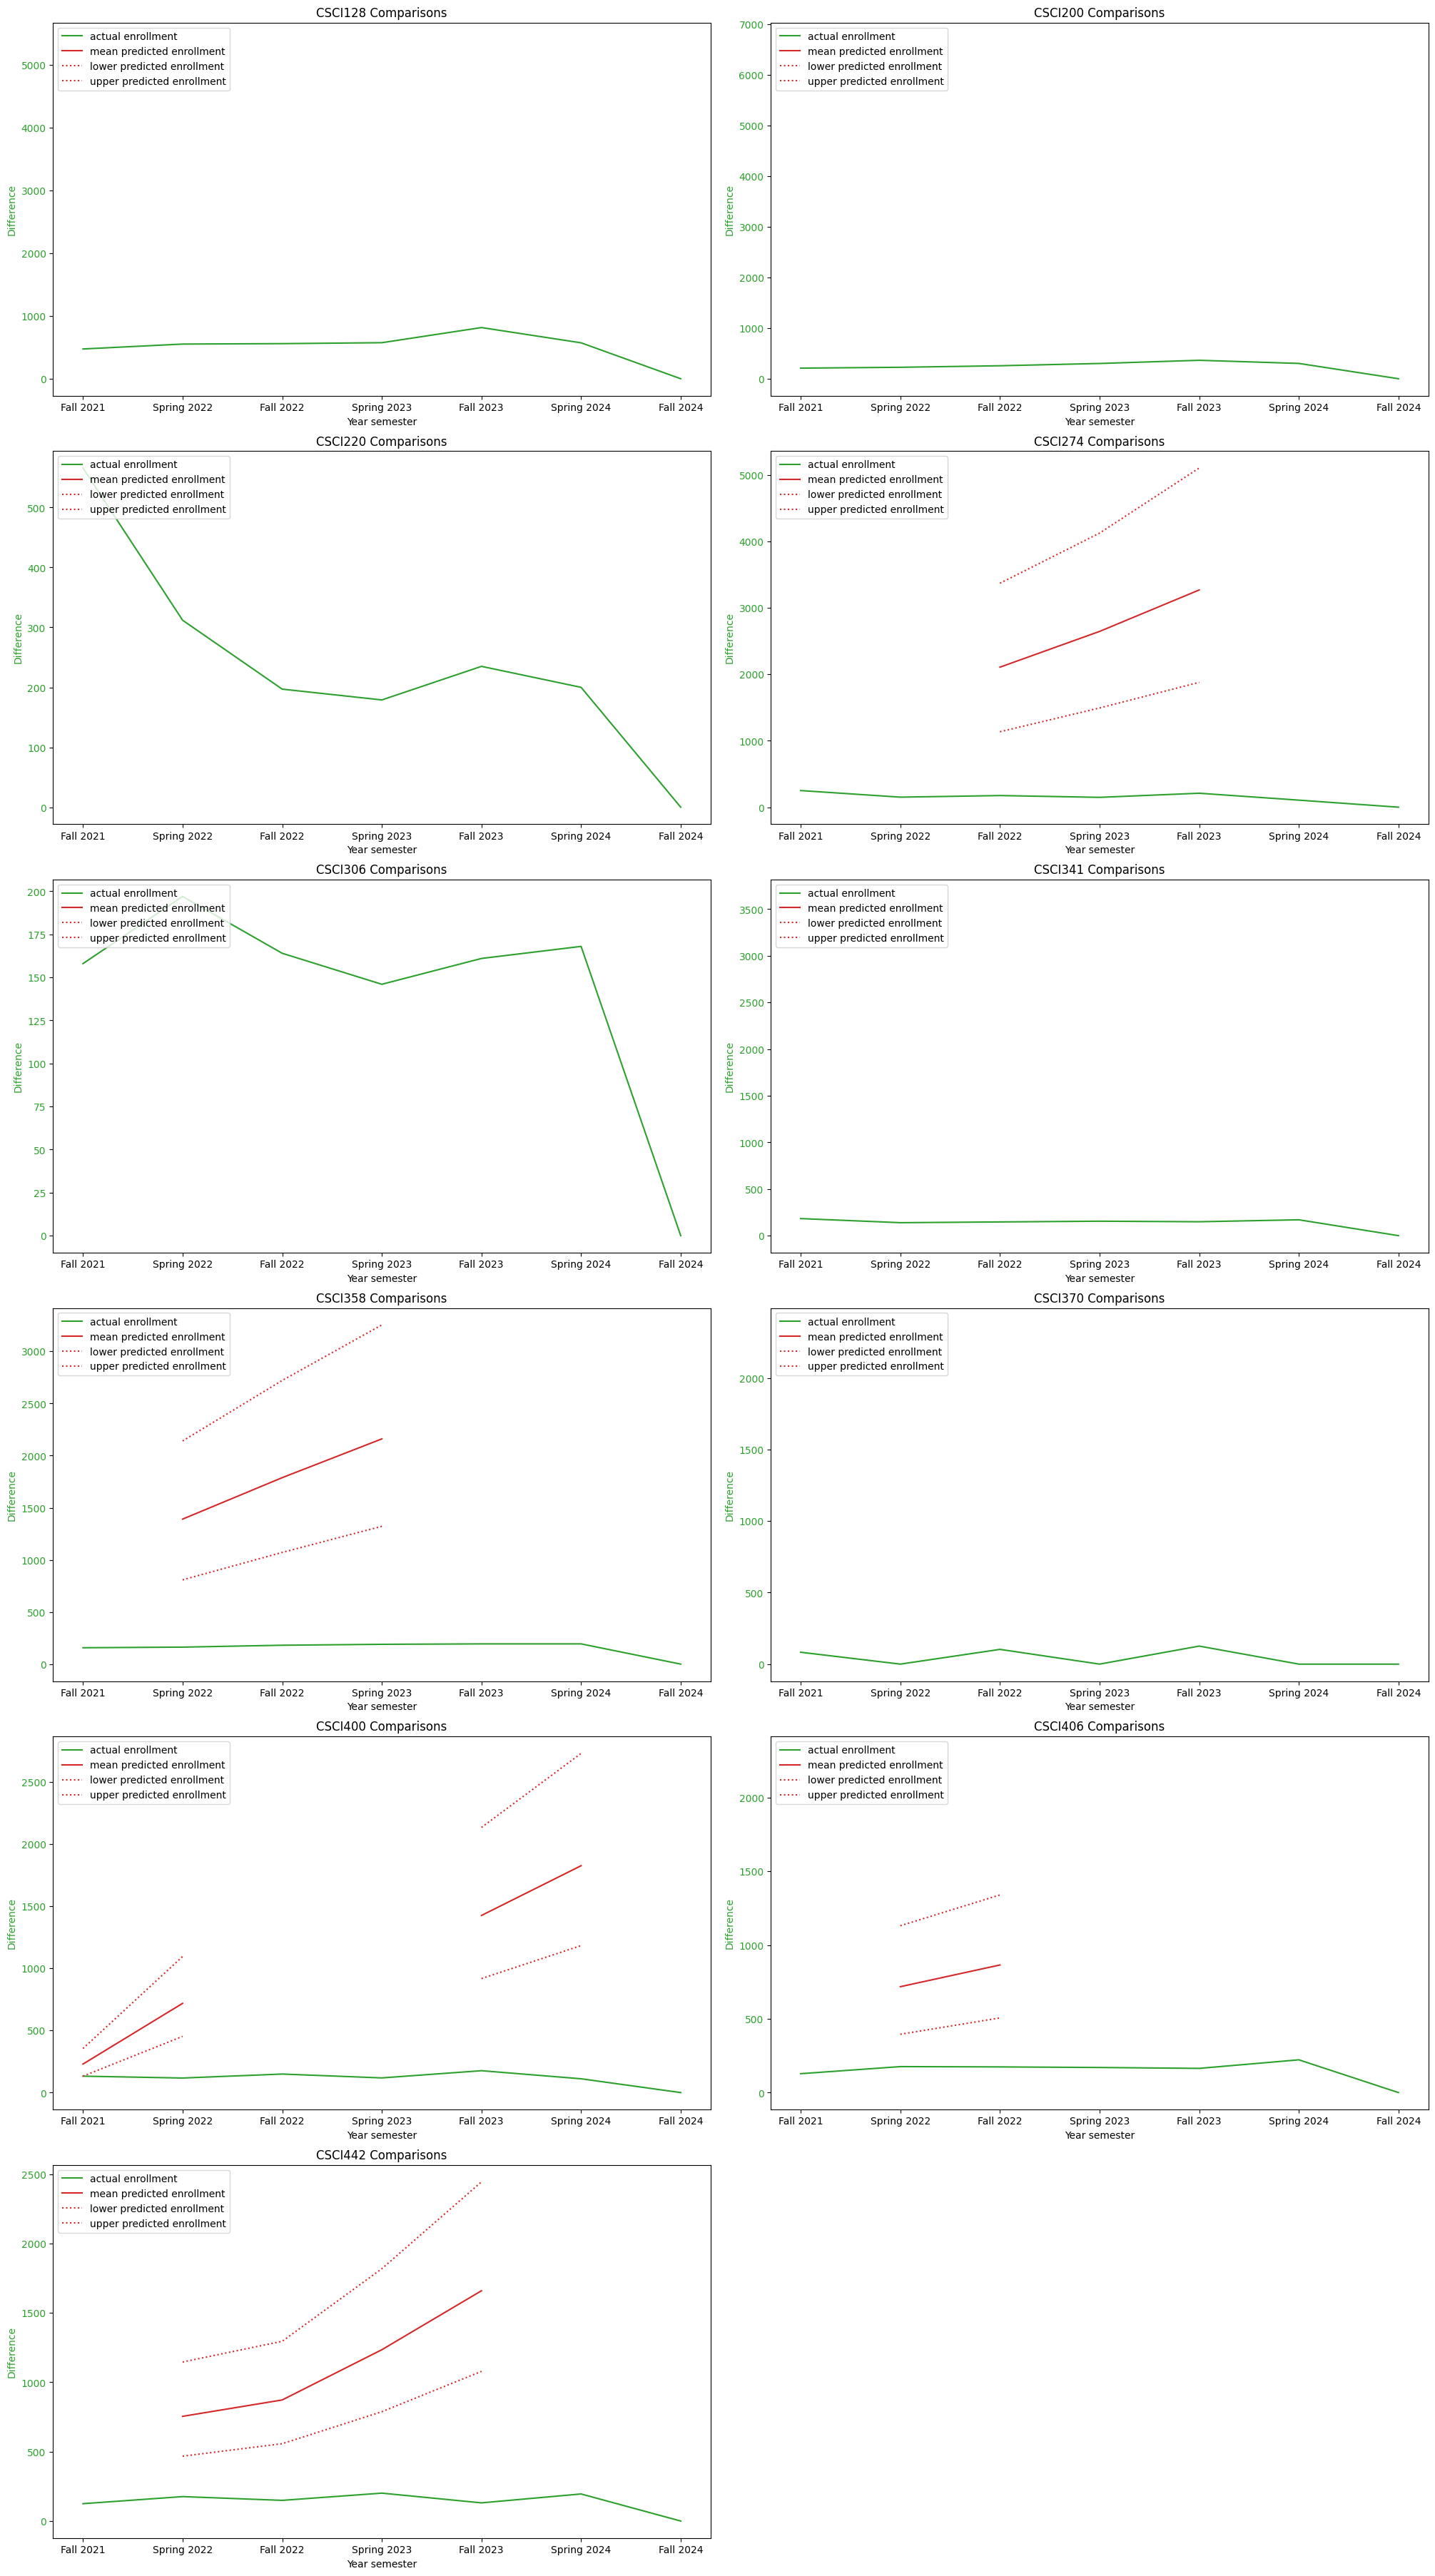

In [240]:
# Calculate the number of rows and columns for the subplot grid
num_classes = len(cs_classes)
num_rows = int(np.ceil(num_classes / 2))  # Adjust the divisor to change the number of columns

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()  # Flatten the array for easy iteration

for i, cl in enumerate(cs_classes):
    plot_df = results_df[results_df['class'] == cl]
    
    # Select the subplot for the current class
    ax1 = axs[i]

    # Plotting on the primary y-axis
    color = 'tab:green'
    ax1.set_xlabel('Year semester')
    ax1.set_ylabel('Difference', color=color)
    ax1.plot(plot_df['year_semester'], plot_df['actual enrollment'], color=color, label='actual enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['mean predicted enrollment'], color='tab:red', label='mean predicted enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['lower predicted enrollment'], color='tab:red', linestyle= 'dotted', label='lower predicted enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['upper predicted enrollment'], color='tab:red', linestyle = 'dotted', label='upper predicted enrollment')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Set the title for the current subplot
    ax1.set_title(f"{cl} Comparisons")

# Hide unused subplots if the number of classes is odd
if num_classes % 2 != 0:
    axs[-1].axis('off')

plt.show()

In [241]:
print(results_df.columns)

Index(['year_semester', 'class', 'true', 'mean difference', 'lower difference',
       'upper difference', 'mean predicted pass', 'lower predicted pass',
       'upper predicted pass', 'actual enrollment', 'capacity', 'pass rate',
       'year', 'semester', 'upper predicted enrollment', 'upper error',
       'lower predicted enrollment', 'lower error',
       'mean predicted enrollment', 'mean error', 'upper error avg',
       'mean error avg', 'lower error avg',
       'upper error_corrected_predicted_enrollment',
       'upper error_corrected_error',
       'lower error_corrected_predicted_enrollment',
       'lower error_corrected_error',
       'mean error_corrected_predicted_enrollment',
       'mean error_corrected_error'],
      dtype='object')


# Post-Error Correction

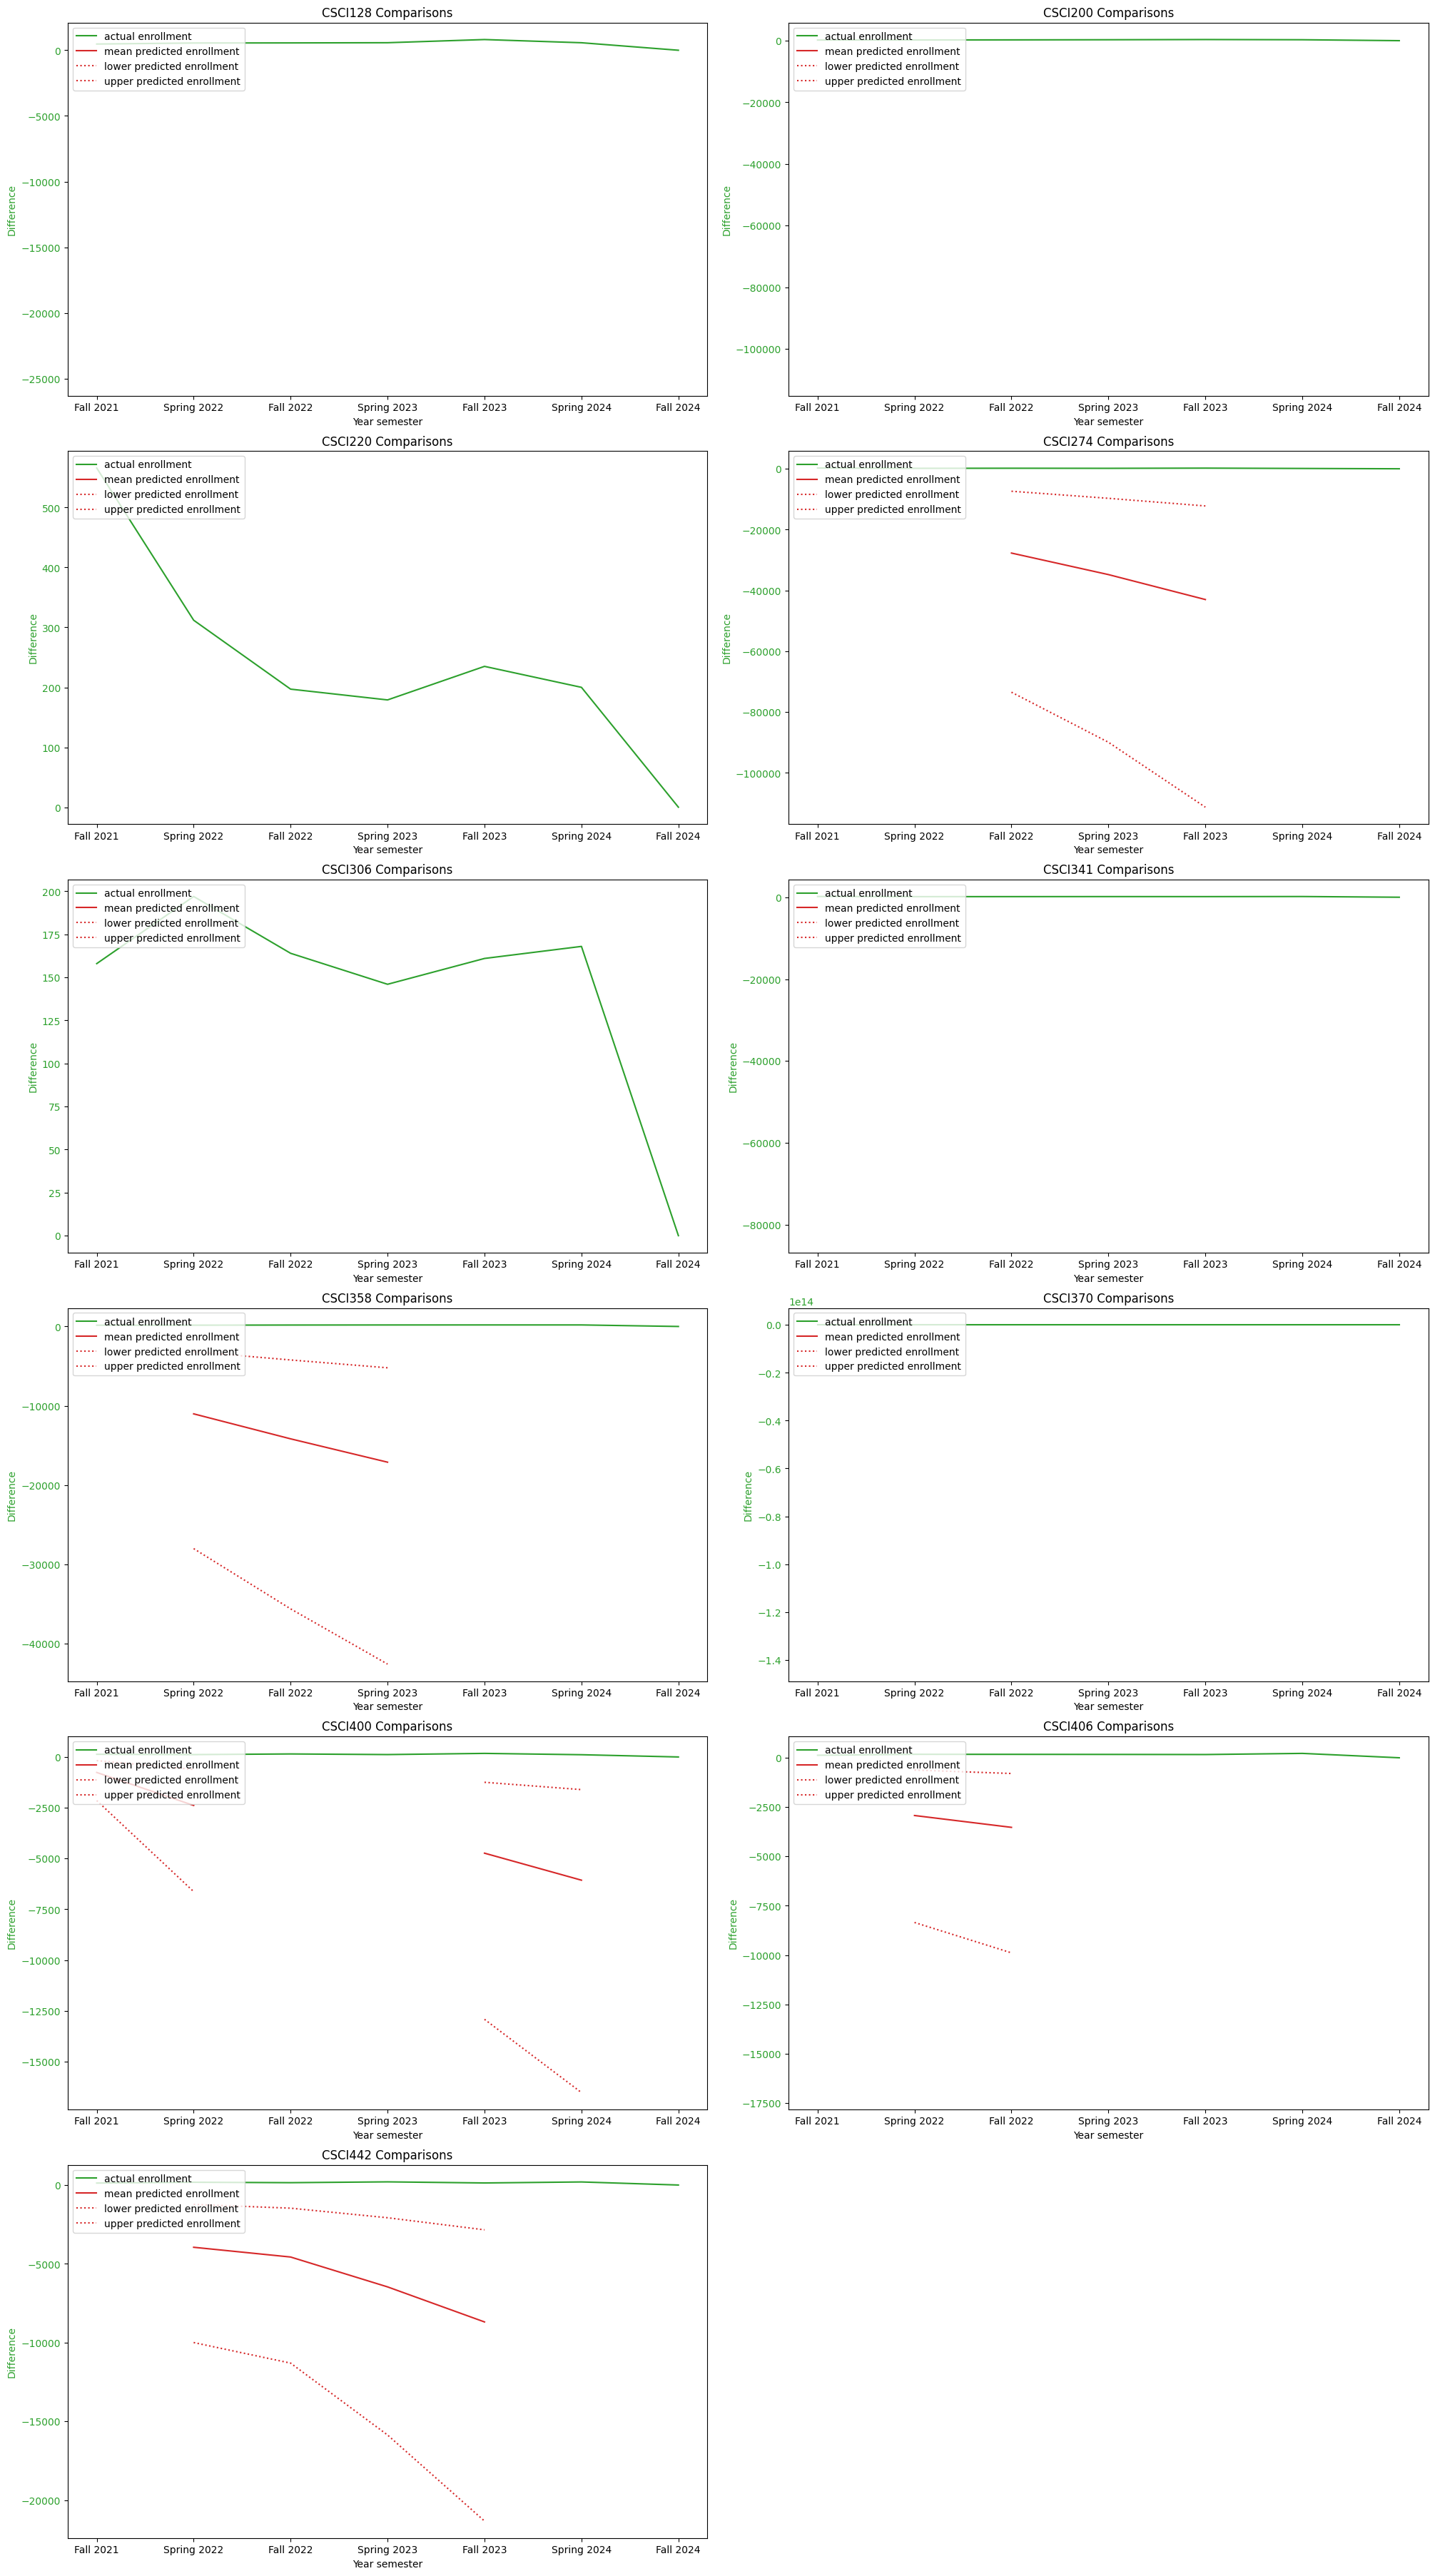

In [242]:
# Calculate the number of rows and columns for the subplot grid
num_classes = len(cs_classes)
num_rows = int(np.ceil(num_classes / 2))  # Adjust the divisor to change the number of columns

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()  # Flatten the array for easy iteration

for i, cl in enumerate(cs_classes):
    plot_df = results_df[results_df['class'] == cl]
    
    # Select the subplot for the current class
    ax1 = axs[i]

    # Plotting on the primary y-axis
    color = 'tab:green'

    ax1.set_xlabel('Year semester')
    ax1.set_ylabel('Difference', color=color)
    ax1.plot(plot_df['year_semester'], plot_df['actual enrollment'], color=color, label='actual enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['mean error_corrected_predicted_enrollment'], color='tab:red', label='mean predicted enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['lower error_corrected_predicted_enrollment'], color='tab:red', linestyle= 'dotted', label='lower predicted enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['upper error_corrected_predicted_enrollment'], color='tab:red', linestyle = 'dotted', label='upper predicted enrollment')
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.legend(loc='upper left')

    # Set the title for the current subplot
    ax1.set_title(f"{cl} Comparisons")

# Hide unused subplots if the number of classes is odd
if num_classes % 2 != 0:
    axs[-1].axis('off')

plt.show()

In [243]:
for cl in error_corrected_predicted_enrollment_dict: 
    print(f"{cl}: {error_corrected_predicted_enrollment_dict[cl]}")

CSCI128: 147.61915778115136
CSCI200: 323.97205190272587
CSCI220: 352.83057140217835
CSCI274: 268.7184272641273
CSCI306: 206.8585820841253
CSCI341: 211.8711164626271
CSCI358: 279.77566846727007
CSCI370: -568846723284.8115
CSCI400: 144.0218443741473
CSCI406: 174.9758678453022
CSCI442: 163.37177596757164


If we had data from the semester directly before the semester we wish to predict, that would help a lot. We'd have solved the problem at this point. 